## Main Jupyter Notebooks for implementing the German Traffic Sign Classification CNN

### Read in Data

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder, DatasetFolder
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt

In [27]:
# Gibt an, ob wir auf einer GPU oder CPU trainieren 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [28]:
transform = transforms.Compose([
    transforms.Resize((35, 35)),  
    transforms.ToTensor(),
    # TODO: Denke das muss man sich nochmal angucken, das hab ausm Internet. Einer in nem video hat da noch mean und std berechnet 
    transforms.Normalize((0.5,), (0.5,)) 
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..1.0].


2


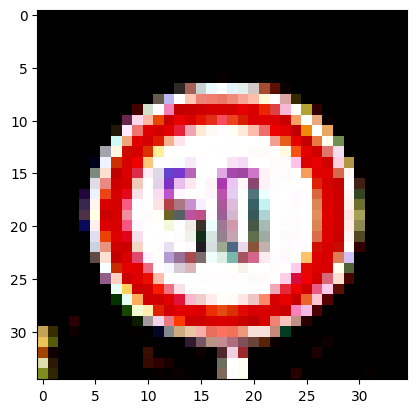

In [29]:
train_dataset = ImageFolder(root='GTSRB/Final_Training/Images', transform=transform)

test_dataset = ImageFolder(root='GTSRB/Final_Test/Images', transform=transform)

# Die Batchsize ist die Anzahl der Bilder, die auf einmal in das Netzwerk eingespeist werden. 
# Heißt es werden pro Trainingsschritt 64 Bilder durch das Netzwerk geschickt, dafür der Loss berechnet und dann für diesen Batch gemittelt, 
# anschließend werden die Parameter auf dem Durchschnittsgradienten aktualisiert.
batch_size = 64
test_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)

num_classes = 43
# --------- Testing ---------
img, label = test_dataset[1230]
label_string = test_dataset.classes[label]
print("Label:", label_string)
plt.imshow(img.permute(1, 2, 0))
#print(img)





### Create the Model

TODO: Über IMG Size sprechen (die meisten nutzen 32x32)

In [42]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=4, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.5)
        
        
        self.fc6 = nn.Linear(128, 512) 
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()

        self.dropout8 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(256, 128)
        self.relu8 = nn.ReLU()


        self.fc9 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)

        out = out.reshape(out.size(0), -1)
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.dropout8(out)
        out = self.fc8(out)
        out = self.relu8(out)

        out = self.fc9(out)

        return out

In [43]:
model = CNN(num_classes).to(device)

loss_func = nn.CrossEntropyLoss()

lr = 0.008 

optimizer = optim.SGD(model.parameters(), lr=lr)

In [44]:
num_epochs = 50
for epoch in range (num_epochs) :
    print(f"Epoch {epoch+1}")
    model.train()
    # load in the data in batches
    for i, (images, labels) in enumerate(train_loader):
        # move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        # forward propagation
        outputs = model(images)
        loss = loss_func(outputs, labels)
        # backward propagation and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

torch.save(model.state_dict(), 'model/base_sgd_model.pth')

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50


In [97]:
with torch.no_grad():
    model.eval()
    correct = 0
    total = 0
    all_val_loss = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        total += labels.size(0)

        predicted = torch.argmax(outputs, 1)
        correct += (predicted == labels).sum().item()
        all_val_loss.append(loss_func(outputs, labels).item())

In [125]:
torch.save(model,'cnn.pt')

In [98]:
print(f"Accuracy: {100 * correct / total}")

Accuracy: 99.80467971459322
